# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [3]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [4]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Bjorn\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [5]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [6]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_test$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

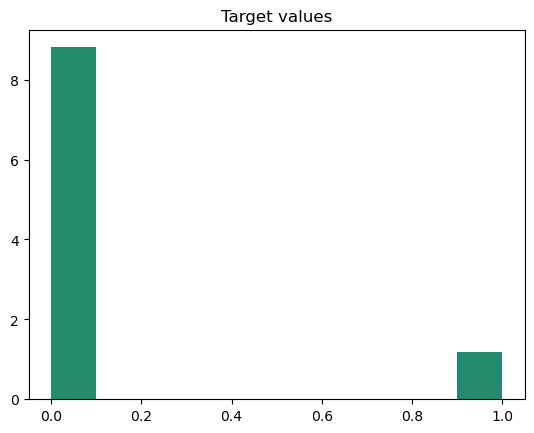

In [7]:
#TODO: visualiser y_train og y_test i et histogram
plt.title("Target values")
plt.hist(y_train, density=True, color="C0", label="train")
#plt.hist(y_test, density=True, color="C1", alpha=0.75, label="val")
plt.hist(y_test, density=True, color="C2", alpha=0.5, label="test")
plt.show() 

**Svar:**

*< Klassifisering fordi det er to valg i mellom >*

<span style='color:red '> Riktig! Target er en binær variabel og derfor er det er klassifiseringsproblem  </span>

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


In [8]:
#TODO: repeterte kryssvalideringer for to modeller

In [18]:
from sklearn.model_selection import RepeatedKFold
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV, cross_val_score

In [19]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)
#clf = RandomForestClassifier()

In [20]:
# modell 1 : RandomForestClassifier

In [21]:
f1_score_clf = []
acc_score_clf = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)):
    #print(f'i = {i}')
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    #logreg = LogisticRegression(solver='lbfgs',max_iter=10000)
    #logreg.fit(X_train_cv, y_train_cv)
    clf = RandomForestClassifier()
    clf.fit(X_train_cv, y_train_cv)
    
    #y_val_hat = logreg.predict_proba(X_val_cv)[:,1]
    y_val_hat = clf.predict_proba(X_val_cv)[:,1]
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)

    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(2)

    f1_score_clf.append(score)
    acc_score_clf.append(score2)

In [22]:
# modell 2: MLPClassifier

In [23]:
f1_score_mlp = []
acc_score_mlp = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)): 
    
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    #mlp = MLPClassifier(random_state=1, max_iter=10000,solver="sgd",learning_rate="adaptive")
    mlp = MLPClassifier()
    mlp.fit(X_train_cv, y_train_cv)
    
    y_val_hat = mlp.predict_proba(X_val_cv)[:,1]
    #print(f'y_hat {y_val_hat}')
    #print(f'y_val_cv {y_val_cv}')
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)
    #print(f'score {(y_val_hat>0.5)*1}')
    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(4)
    
    #print("F1-score = ",score)
    f1_score_mlp.append(score)
    acc_score_mlp.append(score2)

In [24]:
#f1_score_mlp
#acc_score_mlp

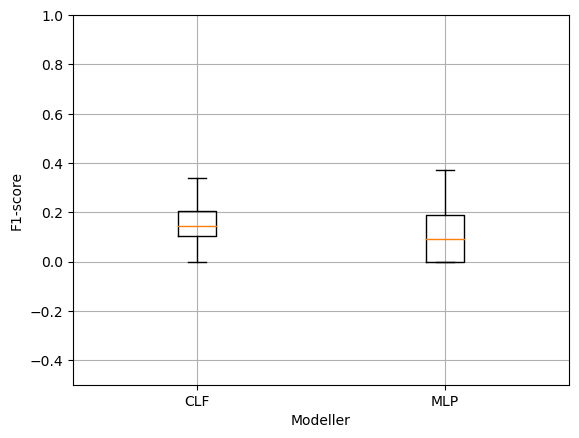

In [25]:
plt.boxplot([np.asarray(f1_score_clf),np.asarray(f1_score_mlp)])
plt.ylim(-0.5,1)
plt.xticks([1,2],["CLF","MLP"])
plt.ylabel("F1-score")
plt.xlabel("Modeller")
plt.grid()
plt.show()

In [26]:
# Fra ChatGPT 14.nov.2023
t_stat, p_value = ttest_rel(f1_score_clf, f1_score_mlp)

print(f't_stat : {t_stat}')
print(f'p_value : {p_value}')
# Check if the difference is statistically significant
alpha = 0.05
if p_value < alpha:
    print("The difference in F1 scores is statistically significant.")
else:
    print("There is no significant difference in F1 scores.")

t_stat : 2.583534761361815
p_value : 0.0128134574635983
The difference in F1 scores is statistically significant.


**Svar:**

*< modell 1 : RandomForestClassifier er nesten like lav som modell 2: MLPClassifier. Fra boxplot viser at f1_score av RandomForestClassifier er lit bedre enn f1_score av MLPClassifier og T-test viser at de ikke er statistisk signifikant. >*

<span style='color:red '> Flott arbeid! Ser ut til at P-verdien ligger helt i grenseland. Når jeg kjørte koden fant jeg signifikant forskjell (p < 0.05), men dette kan være som følge av variansen til modellene og at vi tross alt kjører ganske få kryssvalideringsrunder (5*10)  </span>

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

In [27]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

In [28]:
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,recall_score,precision_score, classification_report, roc_curve, roc_auc_score

In [29]:
#!pip install -U imbalanced-learn

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
# Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen 
#(bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)

In [32]:
sampler = SMOTE(random_state=1,k_neighbors=5)
X_train_upsample, y_train_upsample = sampler.fit_resample(X_train, y_train)

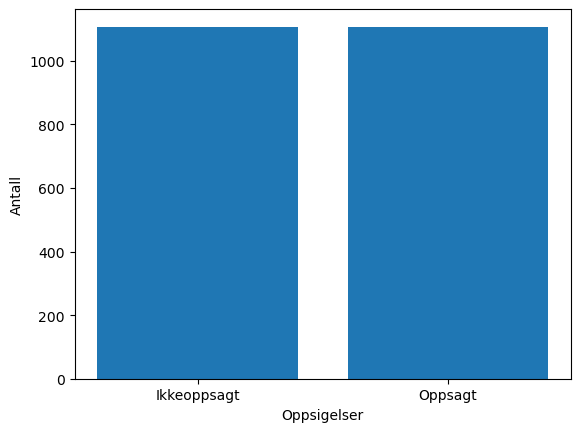

In [33]:
plt.bar(x=np.unique(y_train_upsample, return_counts=True)[0], height= np.unique(y_train_upsample, return_counts=True)[1])
plt.xticks([0,1],["Ikkeoppsagt", "Oppsagt"])
plt.xlabel("Oppsigelser")
plt.ylabel("Antall")
plt.savefig("Balanced.png")
plt.show()

In [34]:
# Modell 1: RandomForestClassifier

In [35]:
sampler = SMOTE(random_state=1,k_neighbors=5)
f1_score_upsample_clf = []
acc_score_upsample_clf = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)): 
    
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_upsample, y_train_upsample = sampler.fit_resample(X_train_cv, y_train_cv)
    
    clf = RandomForestClassifier()
    clf.fit(X_train_upsample, y_train_upsample)
    
    y_val_hat = mlp.predict_proba(X_val_cv)[:,1]

    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)

    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(4)
    

    f1_score_upsample_clf.append(score)
    acc_score_upsample_clf.append(score2)

In [36]:
# Modell 2: MLPClassifier

In [37]:
sampler = SMOTE(random_state=1,k_neighbors=5)
f1_score_upsample_mlp = []
acc_score_upsample_mlp = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)): 
    
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_upsample, y_train_upsample = sampler.fit_resample(X_train_cv, y_train_cv)
    
    mlp = MLPClassifier()
    mlp.fit(X_train_upsample, y_train_upsample)
    
    y_val_hat = mlp.predict_proba(X_val_cv)[:,1]

    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)

    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(4)
    

    f1_score_upsample_mlp.append(score)
    acc_score_upsample_mlp.append(score2)


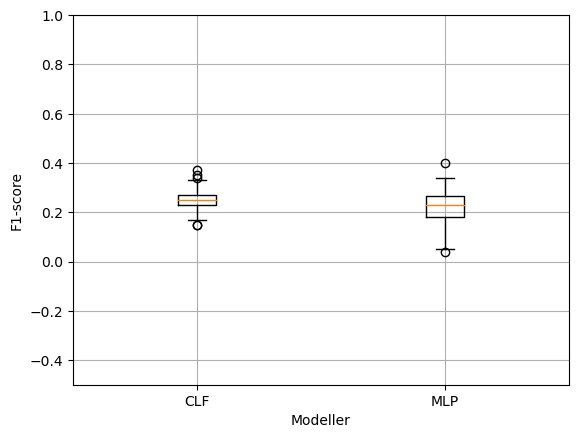

In [38]:
plt.boxplot([np.asarray(f1_score_upsample_clf),np.asarray(f1_score_upsample_mlp)])
plt.ylim(-0.5,1)
plt.xticks([1,2],["CLF","MLP"])
plt.ylabel("F1-score")
plt.xlabel("Modeller")
plt.grid()
plt.show()

In [39]:
# Fra ChatGPT 14.nov.2023
t_stat_upsample, p_value_upsample = ttest_rel(f1_score_upsample_clf, f1_score_upsample_mlp)

print(f't_stat : {t_stat_upsample}')
print(f'p_value : {p_value_upsample}')
# Check if the difference is statistically significant
alpha = 0.05
if p_value_upsample < alpha:
    print("The difference in F1 scores is statistically significant.")
else:
    print("There is no significant difference in F1 scores.")

t_stat : 2.7514305608461718
p_value : 0.008293453372224258
The difference in F1 scores is statistically significant.


**Svar:**

*< Modell 1:RandomForestClassifier  er bedre enn modell 2:MLPClassifier når de er oppsamplet. P_value fra oppgave 2.2 er lavere enn p_value fra oppgave 2.3 >*

<span style='color:red '> Bra jobbet! Savner en kommentar ang. ytelsen med og uten SMOTE. Ble modellene bedre?  </span>

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [40]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

In [41]:
# Tren den beste modellen fra 2.3: den beste modell er clf med oppsamplet data siden den får høyeste F1-score.

In [42]:
sampler = SMOTE(random_state=1,k_neighbors=5)
f1_score_upsample_clf = []
acc_score_upsample_clf = []
for i, (train_index, val_index) in enumerate(rkf.split(X_train)): 
    
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_upsample, y_train_upsample = sampler.fit_resample(X_train_cv, y_train_cv)
    
    clf = RandomForestClassifier()
    clf.fit(X_train_upsample, y_train_upsample)
    
    y_val_hat = mlp.predict_proba(X_val_cv)[:,1]

    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)

    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(4)
    

    f1_score_upsample_clf.append(score)
    acc_score_upsample_clf.append(score2)
    
print("F1-score = ",f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2))
print("Sensitivitet = ",recall_score(y_val_cv,(y_val_hat>0.5)*1,pos_label=1).round(2))
print("Spesifisitet = ",recall_score(y_val_cv,(y_val_hat>0.5)*1,pos_label=0).round(2))
print("Presisjon = ",precision_score(y_val_cv,(y_val_hat>0.5)*1).round(2))
print("Accuracy = ",accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(2))

F1-score =  0.23
Sensitivitet =  1.0
Spesifisitet =  0.1
Presisjon =  0.13
Accuracy =  0.21


### Svar 
F1-score =  0.25
Sensitivitet =  0.53
Spesifisitet =  0.62
Presisjon =  0.16
Accuracy =  0.61

<span style='color:red '> Bra, men savner at du diskuterer resultatene fra kryssvalideringen opp mot resultatene fra testdataene  </span>

#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [43]:
#TODO: Gjør kjønnsbasert analyse på testdataene

In [44]:
#Split data

In [45]:
#X_val_cv.head()
X_test_female = X_val_cv[X_val_cv['Gender'] == 1]
X_test_male = X_val_cv[X_val_cv['Gender'] == 0]


In [46]:
# Analyse av sensitivitet, spesifisitet og presisjon for menn

In [47]:
# Analyse av sensitivitet, spesifisitet og presisjon for Kvinner

In [51]:
sampler = SMOTE(random_state=1,k_neighbors=5)
f1_score_upsample_clf = []
acc_score_upsample_clf = []
for i, (train_male_index, val_index) in enumerate(rkf.split(X_train)): 
    
    
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_upsample, y_train_upsample = sampler.fit_resample(X_train_cv, y_train_cv)
    
    clf = RandomForestClassifier()
    clf.fit(X_train_upsample, y_train_upsample)
    
    y_val_hat = mlp.predict_proba(X_test_male)[:,1]

    
    score = f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2)

    score2 = accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(4)
    

    #f1_score_upsample_clf.append(score)
    #acc_score_upsample_clf.append(score2)
#y_val_hat_male = y_val_hat[y_val_hat['Gender'] == 0]   
print("F1-score Male = ",f1_score(y_val_cv,(y_val_hat>0.5)*1,average='binary').round(2))
print("Sensitivitet Male = ",recall_score(y_val_cv,(y_val_hat>0.5)*1,pos_label=1).round(2))
print("Spesifisitet Male = ",recall_score(y_val_cv,(y_val_hat>0.5)*1,pos_label=0).round(2))
print("Presisjon Male = ",precision_score(y_val_cv,(y_val_hat>0.5)*1).round(2))
print("Accuracy Male = ",accuracy_score(y_val_cv,(y_val_hat>0.5)*1).round(2))

ValueError: Found input variables with inconsistent numbers of samples: [252, 155]

In [ ]:
# Jeg klarer ikke å filtere både X og y data samtidlig. Så sammenligning fungere ikke

<span style='color:red '> Her ble det litt feil. Nedfor har jeg lagt til et løsningsforslag til denne deloppgaven </span>

In [52]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

sampler = SMOTE(random_state=1,k_neighbors=5)

# Assuming you have the predictions (y_pred) and true labels (y_test) for the entire test set

# Split the test set based on gender
women_indices = X_test['Gender'] == 1
men_indices = X_test['Gender'] == 0

X_test_women = X_test.loc[women_indices]
y_test_women = y_test[women_indices]

X_test_men = X_test.loc[men_indices]
y_test_men = y_test[men_indices]

X_train_upsample, y_train_upsample = sampler.fit_resample(X_train_cv, y_train_cv)

clf = RandomForestClassifier()
clf.fit(X_train_upsample, y_train_upsample)

# Predictions for women
y_pred_women = clf.predict(X_test_women)

# Predictions for men
y_pred_men = clf.predict(X_test_men)

# Calculate performance metrics for women
precision_women = precision_score(y_test_women, y_pred_women)
recall_women = recall_score(y_test_women, y_pred_women)
accuracy_women = accuracy_score(y_test_women, y_pred_women)
f1_women = f1_score(y_test_women, y_pred_women)

# Calculate confusion matrix for sensitivity and specificity for women
conf_matrix_women = confusion_matrix(y_test_women, y_pred_women)
tn_women, fp_women, fn_women, tp_women = conf_matrix_women.ravel()
sensitivity_women = tp_women / (tp_women + fn_women)
specificity_women = tn_women / (tn_women + fp_women)

# Print the performance metrics for women
print("Performance Metrics for Women:")
print(f'Precision: {precision_women}')
print(f'Recall (Sensitivity): {sensitivity_women}')
print(f'Specificity: {specificity_women}')
print(f'F1-Score: {f1_women}')
print(f'Accuracy: {accuracy_women}')

# Calculate performance metrics for men
precision_men = precision_score(y_test_men, y_pred_men)
recall_men = recall_score(y_test_men, y_pred_men)
accuracy_men = accuracy_score(y_test_men, y_pred_men)
f1_men = f1_score(y_test_men, y_pred_men)

# Calculate confusion matrix for sensitivity and specificity for men
conf_matrix_men = confusion_matrix(y_test_men, y_pred_men)
tn_men, fp_men, fn_men, tp_men = conf_matrix_men.ravel()
sensitivity_men = tp_men / (tp_men + fn_men)
specificity_men = tn_men / (tn_men + fp_men)

# Print the performance metrics for men
print("\nPerformance Metrics for Men:")
print(f'Precision: {precision_men}')
print(f'Recall (Sensitivity): {sensitivity_men}')
print(f'Specificity: {specificity_men}')
print(f'F1-Score: {f1_men}')
print(f'Accuracy: {accuracy_men}')

Performance Metrics for Women:
Precision: 0.42857142857142855
Recall (Sensitivity): 0.21428571428571427
Specificity: 0.9738562091503268
F1-Score: 0.2857142857142857
Accuracy: 0.9101796407185628

Performance Metrics for Men:
Precision: 0.5238095238095238
Recall (Sensitivity): 0.3055555555555556
Specificity: 0.9539170506912442
F1-Score: 0.3859649122807018
Accuracy: 0.8616600790513834


Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [262]:
!pip freeze > requirements.txt